## VAE for FASHION MNIST : Keras

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
K = keras.backend

tf.random.set_seed(42)
np.random.seed(42)   

### Step 1. Data -  target class : 10

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
#X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
#y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

4423680/4422102 [==============================] - 0s 0us/step
60000 train samples
10000 test samples


## Gaussian Sampling

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

### Step 2. VAE Model

In [ ]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])


print(variational_ae.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
model (Functional)           [(None, 10), (None, 10),  134870    
_________________________________________________________________
model_1 (Functional)         (None, 28, 28)            134634    
Total params: 269,504
Trainable params: 269,504
Non-trainable params: 0
_________________________________________________________________
None


### Step 3. Loss,Optimizer, Metric

In [ ]:
# Step 3. Loss,Optimizer, Metric
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

### Step 4. Train the model

In [ ]:
# Step 4. Train the model
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, verbose=2, validation_split=0.2)

Epoch 1/25
375/375 - 7s - loss: 0.3943 - rounded_accuracy: 0.8567 - val_loss: 0.3542 - val_rounded_accuracy: 0.8951
Epoch 2/25
375/375 - 5s - loss: 0.3447 - rounded_accuracy: 0.8965 - val_loss: 0.3365 - val_rounded_accuracy: 0.9039
Epoch 3/25
375/375 - 5s - loss: 0.3341 - rounded_accuracy: 0.9042 - val_loss: 0.3320 - val_rounded_accuracy: 0.9095
Epoch 4/25
375/375 - 5s - loss: 0.3289 - rounded_accuracy: 0.9084 - val_loss: 0.3294 - val_rounded_accuracy: 0.9095
Epoch 5/25
375/375 - 5s - loss: 0.3257 - rounded_accuracy: 0.9109 - val_loss: 0.3229 - val_rounded_accuracy: 0.9126
Epoch 6/25
375/375 - 5s - loss: 0.3234 - rounded_accuracy: 0.9128 - val_loss: 0.3223 - val_rounded_accuracy: 0.9139
Epoch 7/25
375/375 - 5s - loss: 0.3217 - rounded_accuracy: 0.9142 - val_loss: 0.3230 - val_rounded_accuracy: 0.9147
Epoch 8/25
375/375 - 5s - loss: 0.3203 - rounded_accuracy: 0.9154 - val_loss: 0.3224 - val_rounded_accuracy: 0.9157
Epoch 9/25
375/375 - 5s - loss: 0.3193 - rounded_accuracy: 0.9161 - val_

### Plot the Training/Validation loss

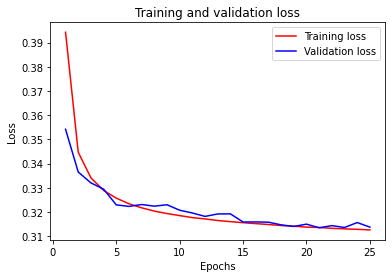

In [ ]:
history_dict = history.history
#print(history_dict.keys())

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'r', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plot images

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

### Show Reconstruction Images

In [ ]:
def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


### Save Imges

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(".", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### Plot multiple images

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

### Show Original and Reconstruected Images

Saving figure reconstruction_plot


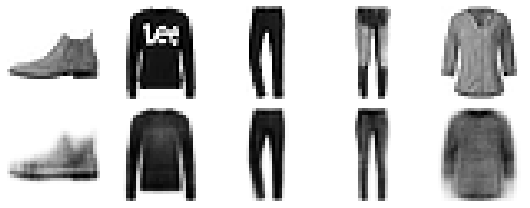

In [ ]:
show_reconstructions(variational_ae)
save_fig("reconstruction_plot")

### Step 5. Show Generate Images

Saving figure vae_generated_images_plot


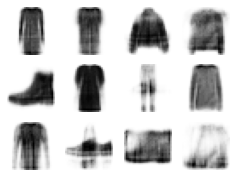

In [ ]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

### Plot the Intepolated Images

Saving figure semantic_interpolation_plot


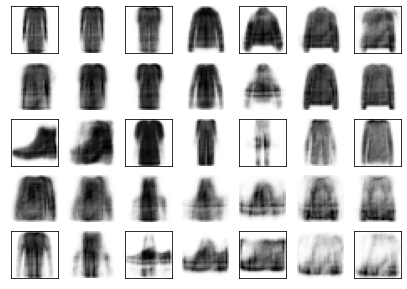

In [ ]:
plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
    
save_fig("semantic_interpolation_plot", tight_layout=False)
